In [1]:
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch
from pykrige.ok import OrdinaryKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk import UniversalKriging
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/hidden_hotspots/'

filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/hidden_hotspots/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [3]:
df = df.drop(['Pusa_IMD'], axis=1)

In [8]:
df_failure_incomplete, df_failure_interpolated = {}, {}
for i in range(10,100,10):
    for j in range(40,45):
        df_name = 'prop{}_seed{}'.format(i,j)
        df_failure_incomplete[df_name] =\
        pd.read_csv("intermediate_data/{}%_random_sensor_failure_incomplete_seed_{}.csv".format(float(i),j),index_col=[0],parse_dates=True)
        df_failure_interpolated[df_name] =\
        pd.read_csv("intermediate_data/{}%_random_sensor_failure_interpolated_seed_{}.csv".format(float(i),j),index_col=[0],parse_dates=True)

In [10]:
df_removed_incomplete, df_removed_interpolated = {}, {}
for i in range(10,100,10):
    for j in range(40,45):
        try:
            df_name = 'prop{}_seed{}'.format(i,j)
            df_removed_incomplete[df_name] =\
            pd.read_csv("intermediate_data/{}%_random_sensors_removed_incomplete_seed_{}.csv".format(float(i),j),index_col=[0],parse_dates=True)
            df_removed_interpolated[df_name] =\
            pd.read_csv("intermediate_data/{}%_random_sensors_removed_interpolated_seed_{}.csv".format(float(i),j),index_col=[0],parse_dates=True)
        except:
            continue

## APH Paper Hotspots

In [11]:
def process_month(df_month):
    freq, scale, cons = [], [], []
    for sensor in df_month.columns:
        if(df_month[sensor].isna().sum()>10):
            continue
        if(len(df_month[sensor][df_month[sensor]>60])>0.6*len(df_month[sensor].dropna())):
            freq.append(sensor)
        if(df_month[sensor].mean()>90):
            scale.append(sensor)
        y = df_month[sensor].dropna()
        y = y-60
        y = (y>0).astype(int)
        y = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
        if(max(y)>=3):
            cons.append(sensor)
    return(freq,scale,cons)

In [12]:
def count_hsps(dataframe): 
    df_18 = dataframe[dataframe.index.year==2018]
    df_19 = dataframe[dataframe.index.year==2019]
    df_20 = dataframe[dataframe.index.year==2020]
    # year 2018
    hsps = {2018:{},2019:{},2020:{}}
    for month in range(5,13):
        df_month = df_18[df_18.index.month==month]    
        hsps[2018][month]=process_month(df_month)


    # year 2019
    for month in range(1,13):
        df_month = df_19[df_19.index.month==month]    
        hsps[2019][month]=process_month(df_month)

    # year 2020
    for month in range(1,10):
        df_month = df_20[df_20.index.month==month]    
        hsps[2020][month]=process_month(df_month)

    return(hsps)

In [13]:
def find_tp_fp_fn(gt, pred):
    tp_list, fp_list, fn_list = [], [], []
    for k in range(3):
        gt_list = gt[k]
        pred_list = pred[k]
        tp_list += [x for x in pred_list if x in gt_list]
        fp_list += [x for x in pred_list if x not in gt_list]
        fn_list += [x for x in gt_list if x not in pred_list]
    return(tp_list, fp_list, fn_list)

In [14]:
df = df.groupby(df.index.date).mean()
df.index = pd.to_datetime(df.index)
for i in range(10,100,10):
    for j in range(40,45):
        key = 'prop{}_seed{}'.format(i,j)
        df_failure_incomplete[key] = df_failure_incomplete[key].groupby(df_failure_incomplete[key].index.date).mean()
        df_failure_interpolated[key] = df_failure_interpolated[key].groupby(df_failure_interpolated[key].index.date).mean()
        df_failure_incomplete[key].index = pd.to_datetime(df_failure_incomplete[key].index)
        df_failure_interpolated[key].index = pd.to_datetime(df_failure_interpolated[key].index)
        try:
            df_removed_incomplete[key] = df_removed_incomplete[key].groupby(df_removed_incomplete[key].index.date).mean()
            df_removed_interpolated[key] = df_removed_interpolated[key].groupby(df_removed_interpolated[key].index.date).mean()
            df_removed_incomplete[key].index = pd.to_datetime(df_removed_incomplete[key].index)
            df_removed_interpolated[key].index = pd.to_datetime(df_removed_interpolated[key].index)
        except:
            continue

In [15]:
gt = count_hsps(df)

In [24]:
df_pr_failure_incomplete = pd.DataFrame(columns=['prop', 'seed', 'precision', 'recall'])
df_pr_removed_incomplete = pd.DataFrame(columns=['prop', 'seed', 'precision', 'recall'])
df_pr_failure_interpolated = pd.DataFrame(columns=['prop', 'seed', 'precision', 'recall'])
df_pr_removed_interpolated = pd.DataFrame(columns=['prop', 'seed', 'precision', 'recall'])

In [25]:
for prop in range(10,100,10):
    for seed in range(40,45):
        key = 'prop{}_seed{}'.format(prop,seed)
        pred = count_hsps(df_failure_incomplete[key])

        tp_list, fp_list, fn_list = [],[],[]
        for i in gt.keys():
            for j in gt[i].keys():
                tp, fp, fn = find_tp_fp_fn(gt[i][j], pred[i][j])
                tp_list += tp
                fp_list += fp
                fn_list += fn

        precision = len(tp_list)/(len(tp_list)+len(fp_list))
        recall = len(tp_list)/(len(tp_list)+len(fn_list))
        # print(prop, seed, precision, recall)
        df_pr_failure_incomplete.loc[len(df_pr_failure_incomplete)] = [prop, seed, precision, recall]

In [26]:
for prop in range(10,100,10):
    for seed in range(40,45):
        key = 'prop{}_seed{}'.format(prop,seed)
        pred = count_hsps(df_failure_interpolated[key])

        tp_list, fp_list, fn_list = [],[],[]
        for i in gt.keys():
            for j in gt[i].keys():
                tp, fp, fn = find_tp_fp_fn(gt[i][j], pred[i][j])
                tp_list += tp
                fp_list += fp
                fn_list += fn

        precision = len(tp_list)/(len(tp_list)+len(fp_list))
        recall = len(tp_list)/(len(tp_list)+len(fn_list))
        # print(prop,seed,precision,recall)
        df_pr_failure_interpolated.loc[len(df_pr_failure_interpolated)] = [prop, seed, precision, recall]

In [27]:
for prop in range(10,100,10):
    for seed in range(40,45):
        try:
            key = 'prop{}_seed{}'.format(prop,seed)
            pred = count_hsps(df_removed_incomplete[key])

            tp_list, fp_list, fn_list = [],[],[]
            for i in gt.keys():
                for j in gt[i].keys():
                    tp, fp, fn = find_tp_fp_fn(gt[i][j], pred[i][j])
                    tp_list += tp
                    fp_list += fp
                    fn_list += fn

            precision = len(tp_list)/(len(tp_list)+len(fp_list))
            recall = len(tp_list)/(len(tp_list)+len(fn_list))
            # print(prop, seed, precision, recall)
            df_pr_removed_incomplete.loc[len(df_pr_removed_incomplete)] = [prop, seed, precision, recall]
        except:
            continue

In [28]:
for prop in range(10,100,10):
    for seed in range(40,45):
        try:
            key = 'prop{}_seed{}'.format(prop,seed)
            pred = count_hsps(df_removed_interpolated[key])

            tp_list, fp_list, fn_list = [],[],[]
            for i in gt.keys():
                for j in gt[i].keys():
                    tp, fp, fn = find_tp_fp_fn(gt[i][j], pred[i][j])
                    tp_list += tp
                    fp_list += fp
                    fn_list += fn

            precision = len(tp_list)/(len(tp_list)+len(fp_list))
            recall = len(tp_list)/(len(tp_list)+len(fn_list))
            # print(prop,seed,precision,recall)
            df_pr_removed_interpolated.loc[len(df_pr_removed_interpolated)] = [prop, seed, precision, recall]
        except:
            continue

In [38]:
df_pr_failure_incomplete.groupby('prop').std().drop('seed',axis=1)['precision'].values

array([0.00120377, 0.00196304, 0.00218111, 0.00199908, 0.0024782 ,
       0.00413802, 0.0046135 , 0.00536593, 0.00998793])

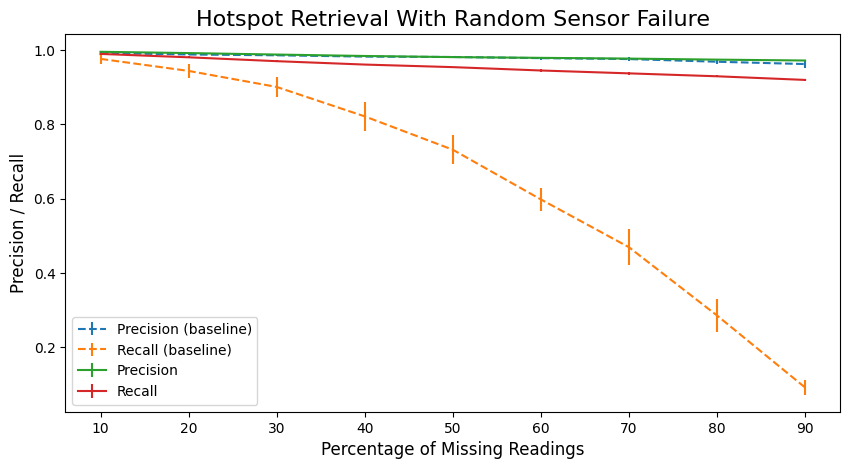

In [52]:
percent = np.arange(10,100,10)
p_base = df_pr_failure_incomplete.groupby('prop').mean().drop('seed',axis=1)['precision'].values
p_base_err = df_pr_failure_incomplete.groupby('prop').std().drop('seed',axis=1)['precision'].values
r_base = df_pr_failure_incomplete.groupby('prop').mean().drop('seed',axis=1)['recall'].values
r_base_err = df_pr_failure_incomplete.groupby('prop').std().drop('seed',axis=1)['recall'].values
p = df_pr_failure_interpolated.groupby('prop').mean().drop('seed',axis=1)['precision'].values
p_err = df_pr_failure_interpolated.groupby('prop').std().drop('seed',axis=1)['precision'].values
r = df_pr_failure_interpolated.groupby('prop').mean().drop('seed',axis=1)['recall'].values
r_err = df_pr_failure_interpolated.groupby('prop').std().drop('seed',axis=1)['recall'].values
fig,ax =  plt.subplots(figsize=(10,5), dpi=100)
plt.errorbar(percent,p_base,p_base_err,label="Precision (baseline)",linestyle='--')
plt.errorbar(percent,r_base,r_base_err,label="Recall (baseline)",linestyle='--')
plt.errorbar(percent,p,p_err,label="Precision")
plt.errorbar(percent,r,r_err,label="Recall")
plt.legend()
plt.title("Hotspot Retrieval With Random Sensor Failure",size=16)
ax.set_xlabel("Percentage of Missing Readings",size=12)
ax.set_ylabel("Precision / Recall",size=12)
fig.savefig('table2.jpeg')

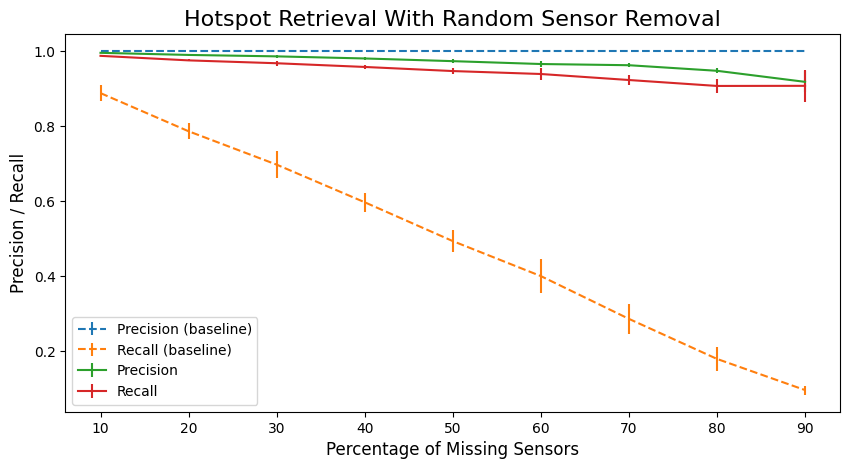

In [53]:
percent = np.arange(10,100,10)
p_base = df_pr_removed_incomplete.groupby('prop').mean().drop('seed',axis=1)['precision'].values
p_base_err = df_pr_removed_incomplete.groupby('prop').std().drop('seed',axis=1)['precision'].values
r_base = df_pr_removed_incomplete.groupby('prop').mean().drop('seed',axis=1)['recall'].values
r_base_err = df_pr_removed_incomplete.groupby('prop').std().drop('seed',axis=1)['recall'].values
p = df_pr_removed_interpolated.groupby('prop').mean().drop('seed',axis=1)['precision'].values
p_err = df_pr_removed_interpolated.groupby('prop').std().drop('seed',axis=1)['precision'].values
r = df_pr_removed_interpolated.groupby('prop').mean().drop('seed',axis=1)['recall'].values
r_err = df_pr_removed_interpolated.groupby('prop').std().drop('seed',axis=1)['recall'].values
fig,ax =  plt.subplots(figsize=(10,5), dpi=100)
plt.errorbar(percent,p_base,p_base_err,label="Precision (baseline)",linestyle='--')
plt.errorbar(percent,r_base,r_base_err,label="Recall (baseline)",linestyle='--')
plt.errorbar(percent,p,p_err,label="Precision")
plt.errorbar(percent,r,r_err,label="Recall")
plt.legend()
plt.title("Hotspot Retrieval With Random Sensor Removal",size=16)
ax.set_xlabel("Percentage of Missing Sensors",size=12)
ax.set_ylabel("Precision / Recall",size=12)
fig.savefig('table1.jpeg')